In [182]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm, ttest_ind
import os
from datetime import datetime, timedelta
import pandas as pd
import seaborn as sns

In [139]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'
def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE,file_name))

In [140]:
df_sales=read_database('2022-04-01T12_df_sales.csv')
df_sales['date']=pd.to_datetime(df_sales['date'])
df_users=read_database('experiment_users.csv')

df_sales - information about purchases, one row - one order. Attributes:
- sale_id - purchase identifier;
- date - date of purchase;
- count_pizza - number of pizzas in the order;
- count_drink - number of drinks in the order;
- price - price of the order;
- user_id - user identifier;

df_users - list of users of the experiment broken down into groups

In [141]:
df_users.head()

,user_id,pilot
0,0ffc65,0
1,b962b9,0
2,7ea63f,0
3,7f9a61,0
4,459e55,0


In [142]:
df_users['pilot'].value_counts()

0    11769
1    11564
Name: pilot, dtype: int64

In [143]:
df_sales.head()

,sale_id,date,count_pizza,count_drink,price,user_id
0,1000001,2022-02-04 10:00:24,1,0,720,1c1543
1,1000002,2022-02-04 10:02:28,1,1,930,a9a6e8
2,1000003,2022-02-04 10:02:35,3,1,1980,23420a
3,1000004,2022-02-04 10:03:06,1,1,750,3e8ed5
4,1000005,2022-02-04 10:03:23,1,1,870,cbc468


In [144]:
# Calculate a metric
begin_daie=datetime(2022,3,23)
end_date=datetime(2022,3,30)
df_metrics=(
    df_sales[(df_sales['date']>=begin_daie)&(df_sales['date']<=end_date)].groupby('user_id')[['price']].sum().reset_index()
)

In [145]:
df_metrics.head()

,user_id,price
0,0000d4,720
1,0000de,660
2,0000e4,840
3,0001e2,2430
4,0001ff,720


In [146]:
df_users_metrics=pd.merge(df_users,df_metrics,how='left',on='user_id').fillna(0)
df_users_metrics.head()


,user_id,pilot,price
0,0ffc65,0,0.0
1,b962b9,0,840.0
2,7ea63f,0,0.0
3,7f9a61,0,0.0
4,459e55,0,0.0


In [147]:
data_control=df_users_metrics[df_users_metrics['pilot']==0]['price']
data_pilot=df_users_metrics[df_users_metrics['pilot']==1]['price']
stats.ttest_ind(data_control,data_pilot)

Ttest_indResult(statistic=-7.800743549967138, pvalue=6.411291718224787e-15)

**Conclusion:** 
- At the significance level of 0.05, the hypothesis of equality of mean is rejected
- The change is statistically significant

In [148]:
# Calculate a metric for a period
begin_daie=datetime(2022,3,16)
end_date=datetime(2022,3,23)
df_metrics=(
    df_sales[(df_sales['date']>=begin_daie)&(df_sales['date']<=end_date)].groupby('user_id')[['price']].sum().reset_index()
)
df_users_metrics=pd.merge(df_users,df_metrics,how='left',on='user_id').fillna(0)
data_control=df_users_metrics[df_users_metrics['pilot']==0]['price']
data_pilot=df_users_metrics[df_users_metrics['pilot']==1]['price']
stats.ttest_ind(data_control,data_pilot)

Ttest_indResult(statistic=-1.2837567415000515, pvalue=0.19923983306424942)

**Conclusion:** 
- At the significance level of 0.05, the hypothesis of equality of mean is accepted
- The change is not statistically significant

In [149]:
#Estimate the average time between purchases for customers with 2 or more purchases 

df_2=df_sales.groupby('user_id')[['date']].agg(['count','min','max'])
df_2.columns = [x[1] for x in df_2.columns] # fix column headings 
df_2=df_2[df_2['count']>=2]
df_2['delta']=(df_2['max']-df_2['min']).dt.total_seconds()
sum_delta=df_2['delta'].sum() # total time (in sec) between purchases
count_periods = df_2['count'].sum() - len(df_2) # total number periods between purchases
result=sum_delta/count_periods/3600/24

print("average time between purchases - ", int(round(result)), "days")





average time between purchases -  17 days


In [150]:
# Function to get p-value 

def get_ttest_pvalue(metrics_a_group,metrics_b_group):
   return print("pvalue =",(stats.ttest_ind(metrics_a_group,metrics_b_group).pvalue))

    

In [151]:
def get_ttest_pvalue(metrics_a_group, metrics_b_group):
    _, pvalue = stats.ttest_ind(metrics_a_group, metrics_b_group)
    return pvalue

In [152]:
# Test the function with example data
metrics_a_group = np.array([964, 1123, 962, 1213, 914, 906, 951, 1033, 987, 1082])
metrics_b_group = np.array([952, 1064, 1091, 1079, 1158, 921, 1161, 1064, 819, 1065])
pvalue = get_ttest_pvalue(metrics_a_group, metrics_b_group)


### MDE. Sample size

In [153]:
web_logs=read_database('2022-04-01T12_df_web_logs.csv')

In [154]:
web_logs.head()


,user_id,page,date,load_time
0,f25239,m,2022-02-03 23:45:37,80.8
1,06d6df,m,2022-02-03 23:49:56,70.5
2,06d6df,m,2022-02-03 23:51:16,89.7
3,f25239,m,2022-02-03 23:51:43,74.4
4,697870,m,2022-02-03 23:53:12,66.8


Web-logs - table with logs of site visits.

1. user_id - user ID;
2. page - what page of the site was opened. Page types:
    + m - page with menu;
    + b - page with cart and order confirmation;
    + p - page with order payment;
3. date - date of page opening;
4. load_time - page load time in milliseconds.

**The data is assumed to be independent**

min date- 2022-02-03 23:45:37 max_date- 2022-04-01 11:59:57
(1964507, 4)


<AxesSubplot:>

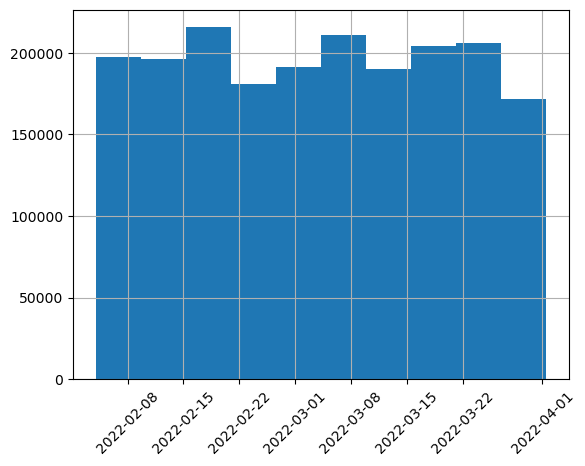

In [155]:
web_logs['date']=pd.to_datetime(web_logs['date'])
print('min date-',web_logs['date'].min(),'max_date-',web_logs['date'].max())
print(web_logs.shape)
web_logs['date'].hist(xrot=45)

In [156]:
#Suppose we want to run the test for one week.
web_logs_hist=web_logs[
    (web_logs['date']>=datetime(2022,3,22)) &
    (web_logs['date']<datetime(2022,3,29))
]
web_logs_hist.shape

(247163, 4)

In [157]:
# for an equel variance 
def get_sample_size_abs(epsilon, std, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * (2 * std ** 2) / (epsilon ** 2)
        )
    )
    return sample_size

def get_sample_size_arb(mu, std, effect_size=1.01, alpha=0.05, beta=0.2): # if we want to calculete relative effect size
    epsilon = (effect_size - 1) * mu

    return get_sample_size_abs(epsilon, std=std, alpha=alpha, beta=beta)

We want to be able to detect 1% effect in the page load time with a high probability.

In [158]:
# Experiment parameters

alpha=0.05 # significance level
beta=0.2 # power of the test
effect_size=1.01 # 1% effect 

mean=web_logs_hist['load_time'].mean()
std=web_logs_hist['load_time'].std()
print(mean,std)

74.09834562616594 111.56972405581025


In [159]:
sample_size=get_sample_size_abs(mean/100,std,alpha=alpha,beta=beta) 
print("Sample size for each group:", sample_size)


Sample size for each group: 355889


Since sample size for each group is 355889, the experiment requires 700 000 observations, while we have only 247 000. 
What effect can be detected with current amount of oservations? 

In [160]:
def get_minimal_determinable_effect (std,sample_size, alpha=0.05, beta=0.2):
    t_alpha=norm.ppf(1-alpha/2, loc=0,scale=1)
    t_beta=norm.ppf(1-beta, loc=0,scale=1)
    disp_sum_sqrt = (2 * (std ** 2)) ** 0.5
    mde = (t_alpha + t_beta) * disp_sum_sqrt / np.sqrt(sample_size)
    return mde

In [161]:
mde=get_minimal_determinable_effect(std,web_logs_hist.shape[0] //2,alpha=alpha,beta=beta)
print(f'mde = {np.round(mde, 3)}')
print(f'mde = {np.round(mde / mean * 100, 3)}%')

mde = 1.257
mde = 1.697%


with 247 000 observations we can detect 1.697% effect 

How many pages downloads do we need to detect 3% effect? 

In [162]:
alpha = 0.05
beta = 0.2
eff = 1.03
sample_size=get_sample_size_arb(mean,std,effect_size=eff,alpha=alpha,beta=beta)
print(f'sample_size = {sample_size}')

sample_size = 39544


How many customers do we need in each group? 

In [163]:
ratio=web_logs_hist.groupby(['user_id'])['load_time'].count().mean()
print(ratio)

7.015298592188919


In [164]:
n_users=int(sample_size/ratio)+1
print(f'n_users = {n_users}')

n_users = 5637


Therefore, based on historical data, each group requires 6,000 users to be allocated to each group that will generate enough traffic that we are able to capture the 3% effect at a significance level of 0.05 and a power of 0

In [165]:


sales=read_database('2022-04-01T12_df_sales.csv')
sales['date']=pd.to_datetime(sales['date'])
sales_hist=sales[
    (sales['date']>=datetime(2022,2,21)) &
    (sales['date']<datetime(2022,2,28))
]
sales_hist.head() 


,sale_id,date,count_pizza,count_drink,price,user_id
63207,1063208,2022-02-21 10:02:02,4,1,3030,fcaa0f
63208,1063209,2022-02-21 10:04:43,3,1,2250,8d8445
63209,1063210,2022-02-21 10:05:40,1,0,780,e21af3
63210,1063211,2022-02-21 10:09:01,4,0,2880,e23104
63211,1063212,2022-02-21 10:11:20,2,1,1620,748932


In [166]:
begin_date = datetime(2022, 2, 21)
end_date = datetime(2022, 2, 28)
df_metrics = (
    df_sales
    [(df_sales['date'] >= begin_date) & (df_sales['date'] < end_date)]
    .groupby('user_id')[['price']].sum()
    .reset_index())
df_metrics.shape

(24840, 2)

In [167]:
sales_hist.shape

(25347, 6)

In [168]:
mean=sales_hist['price'].mean()
std=sales_hist['price'].std()
print(mean,std)

1209.9905314238372 783.1782330895605


In [169]:
mean=df_metrics['price'].mean()
std=df_metrics['price'].std()
print(mean,std)

1234.6871980676328 811.1803387604872


In [170]:
sample_size=get_sample_size_abs(20, std, alpha=alpha, beta=beta)
alpha = 0.05
beta = 0.1
eff = 20 # 20 usd effect 
print(f'sample_size = {round(sample_size,-1)}')

sample_size = 25820


In [173]:
mde=get_minimal_determinable_effect(std,df_metrics.shape[0]//2,alpha=alpha,beta=beta)
print(f'mde = {np.round(mde, 3)}')
print(f'mde = {np.round(mde / mean * 100, 3)}%')

mde = 33.367
mde = 2.702%


In [176]:
def estimate_sample_size(metrics, effect, alpha, beta):
    std = np.std(metrics['metric'].values)
    mean = np.mean(metrics['metric'].values)
    epsilon = effect / 100 * mean
    # ratio of the number of unique users to the number of observations
    coef = metrics['user_id'].nunique() / len(metrics)
    t_alpha = stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * (2 * std ** 2) / (epsilon ** 2) * coef
        )
    )
    return sample_size

### Experiment design test

In [177]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

web_logs = read_database('2022-04-01T12_df_web_logs.csv')

In [178]:
sales = read_database('2022-04-01T12_df_sales.csv')
sales['date'] = pd.to_datetime(sales['date'])
sales.head(3)

,sale_id,date,count_pizza,count_drink,price,user_id
0,1000001,2022-02-04 10:00:24,1,0,720,1c1543
1,1000002,2022-02-04 10:02:28,1,1,930,a9a6e8
2,1000003,2022-02-04 10:02:35,3,1,1980,23420a


2022-02-04 10:00:24
2022-04-01 11:59:51
(203847, 6)


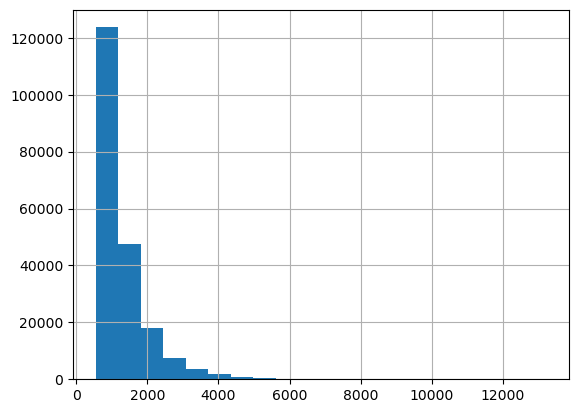

In [179]:
print(sales['date'].min())
print(sales['date'].max())
print(sales.shape)
sales['price'].hist(bins=20);

Let's assume that we want to run the test for 4 weeks.

For this purpose, we will choose an interval of one week on the historical interval and perform all calculations for this time interval. Note that today is April 1, so we have taken the week immediately before the start of the experiment.

In [181]:
sales_hist=sales[
    (sales['date']>=datetime(2022,3,1)) &
    (sales['date']<datetime(2022,3,29))
]
sales_hist.shape

(101951, 6)

In [185]:
def plot_pvalue_ecdf(pvalues, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if title:
        plt.suptitle(title)

    sns.histplot(pvalues, ax=ax1, bins=20, stat='density')
    ax1.plot([0,1],[1,1], 'k--')
    ax1.set(xlabel='p-value', ylabel='Density')

    sns.ecdfplot(pvalues, ax=ax2)
    ax2.plot([0,1],[0,1], 'k--')
    ax2.set(xlabel='p-value', ylabel='Probability')
    ax2.grid()

To check the correctness of the experiment design, we must simulate this experiment on historical data many times. First, let us check whether the probability of the 1st type of error is controlled. For this purpose, the objects in our sample will be **checks**. That is, we divide all people into 2 groups, collect all checks independently, and run a t-test.

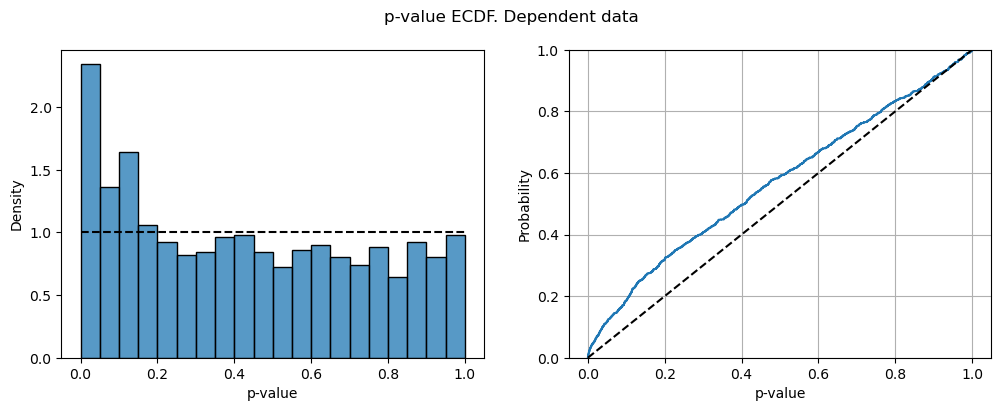

In [186]:
p_values=[]
users=sales_hist['user_id'].unique()
for _ in range(1000):
    np.random.shuffle(users)
    group_a,group_b=users[:len(users) // 2],users[len(users) // 2:]
    sales_a=sales_hist[sales_hist['user_id'].isin(group_a)]['price']
    sales_b=sales_hist[sales_hist['user_id'].isin(group_b)]['price']
    _, p_value=ttest_ind(sales_a,sales_b)
    p_values.append(p_value)
plot_pvalue_ecdf(p_values, 'p-value ECDF. Dependent data')

In [188]:
print((np.array(p_values) < 0.05).mean(),'real probability of false positive result (I type error) with significance level 0.05')

0.117 real probability of false positive result (I type error) with significance level 0.05


This behavior is due to the fact that the sample does not satisfy the regularity conditions of the t-test, in particular, the observations are **not independent** because one person may make multiple purchases during the experiment.

To make the data independent, let's calculate the metric **average check per user**. The data will be statistically independent, because we will get one value from each user, and users are independent among themselves.

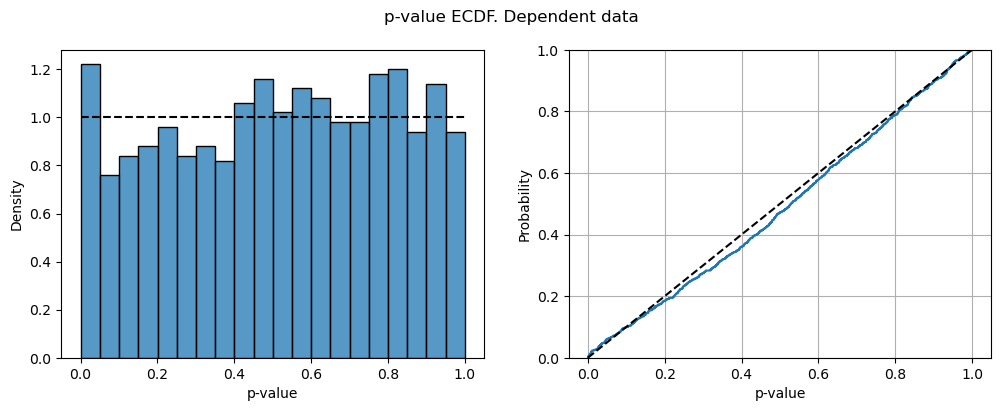

In [189]:
p_values=[]
grouped_sales=sales_hist.groupby('user_id')['price'].mean().reset_index()
users=sales_hist['user_id'].unique()
for _ in range(1000):
    np.random.shuffle(users)
    group_a,group_b=users[:len(users) // 2],users[len(users) // 2:]
    sales_a=grouped_sales[grouped_sales['user_id'].isin(group_a)]['price']
    sales_b=grouped_sales[grouped_sales['user_id'].isin(group_b)]['price']
    _, p_value=ttest_ind(sales_a,sales_b)
    p_values.append(p_value)
plot_pvalue_ecdf(p_values, 'p-value ECDF. Dependent data')

Test power 

In [193]:
mean =grouped_sales['price'].mean()
std= grouped_sales['price'].std()
sample_size=grouped_sales.shape[0] // 2
alpha0= 0.05
beta0= 0.2
mde = get_minimal_determinable_effect(std, sample_size, alpha=alpha0, beta=beta0)
print(f'mde = {np.round(mde, 3)}')

mde = 15.866


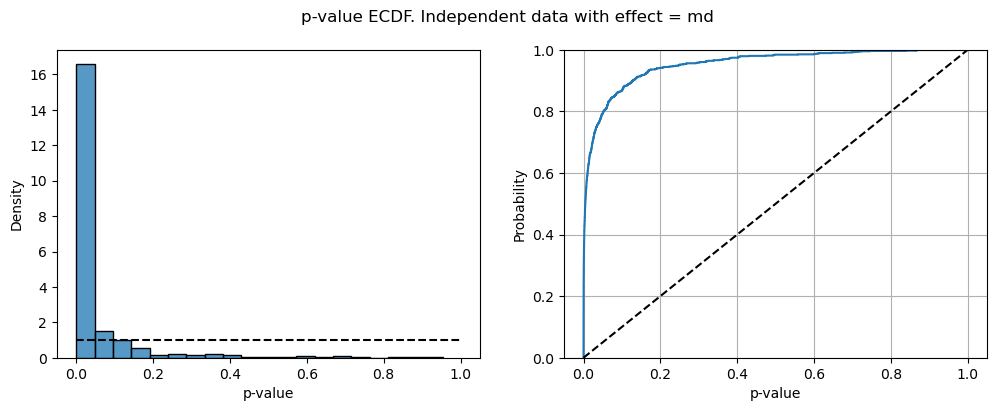

In [ ]:
#Test power
p_values=[]
grouped_sales=sales_hist.groupby('user_id')['price'].mean().reset_index()
users=sales_hist['user_id'].unique()
for _ in range(1000):
    np.random.shuffle(users)
    group_a,group_b=users[:len(users) // 2],users[len(users) // 2:]
    sales_a=grouped_sales[grouped_sales['user_id'].isin(group_a)]['price']
    sales_b=grouped_sales[grouped_sales['user_id'].isin(group_b)]['price']
    sales_b +=np.random.normal(mde,std // 10,sales_b.shape)   # adding a synthetic effect to historical data + a bit of variance
    _, p_value=ttest_ind(sales_a,sales_b)
    p_values.append(p_value)
plot_pvalue_ecdf(p_values, 'p-value ECDF. Independent data with effect = md')

The power of the test on 80% probability to detect a MDE.